# PROJECT: An Attempt at FashionMNIST dataset
## A Computer Vision Problem using Deep Learning

In [1]:
# Importing Libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [2]:
# Importing a custom wrapper created for Classification Models.
from torcus.classification import CModel, CMetrics

In [3]:
# Fetching training and testing data from torchvision datasets
train_data = datasets.FashionMNIST(root="data",
                                   train=True,
                                   transform=transforms.ToTensor(),
                                   download=True)
test_data = datasets.FashionMNIST(root="data",
                                  train=False,
                                  transform=transforms.ToTensor(),
                                  download=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:07<00:00, 3.41MB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 156kB/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:02<00:00, 1.75MB/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 5.14MB/s]


In [4]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
# Extract a feature-target pair for verification
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [6]:
# Checking class names
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
# Checking class order
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
# Checking if class_names is in correct order.
for c, k in zip(class_names, train_data.class_to_idx.keys()):
    print("False") if c != k else None

In [9]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

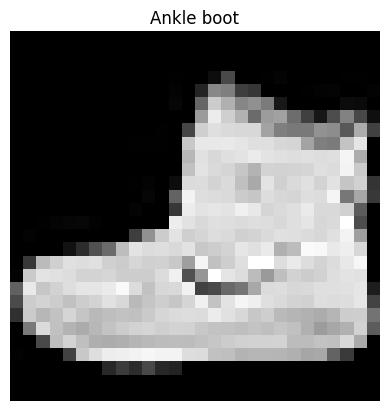

In [10]:
# Display the previously extracted feature-target pair.
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
plt.show()

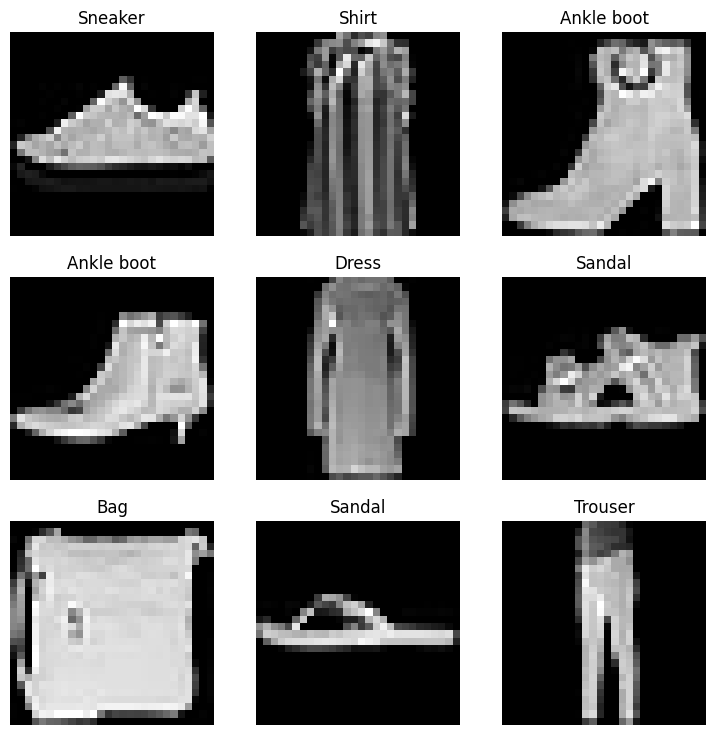

In [11]:
# Create a 3x3 plot to display randomly extracted feature-target pairs from the training dataset.
fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3
for i in range(1, (rows*cols) + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, lbl = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[lbl])
    plt.axis(False)

In [12]:
BATCH_SIZE = 64

# train_dl = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
# test_dl = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# train_dl

In [13]:
# Define the CNN Model as a subclass of nn.Module. An instance of this class will be passed to the CModel class.
class FashionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.relu = nn.ReLU()
        self.bnorm1 = nn.BatchNorm2d(32)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.flat1 = nn.Flatten()
        self.dense1 = nn.Linear(32*13*13, 128)
        self.dropout1 = nn.Dropout(0.25)
        self.output_layer = nn.Linear(128, 10)

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.maxpool(self.bnorm1(out))
        out = self.flat1(out)
        out = self.relu(self.dense1(out))
        out = self.output_layer(self.dropout1(out))
        return torch.softmax(out, dim=1)

nn_model = FashionNet()

In [14]:
# Create a CModel class with previously created model.
model = CModel(model=nn_model, num_classes=len(class_names), input_size=image.unsqueeze(0).shape)

In [15]:
# Show the model's summary.
model.summary()

Layer (type:depth-idx)                   Output Shape              Param #
FashionNet                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─ReLU: 1-2                              [1, 32, 26, 26]           --
├─BatchNorm2d: 1-3                       [1, 32, 26, 26]           64
├─MaxPool2d: 1-4                         [1, 32, 13, 13]           --
├─Flatten: 1-5                           [1, 5408]                 --
├─Linear: 1-6                            [1, 128]                  692,352
├─ReLU: 1-7                              [1, 128]                  --
├─Dropout: 1-8                           [1, 128]                  --
├─Linear: 1-9                            [1, 10]                   1,290
Total params: 694,026
Trainable params: 694,026
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.91
Input size (MB): 0.00
Forward/backward pass size (MB): 0.35
Params size (MB): 2.78
Estimated Total Size 

In [16]:
# Load the data into the class and check if it loaded properly.
model.load_data(train_data=train_data, test_data=test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
model._dataloader_check()
model._dataset_check()

In [17]:
# Verifying the tracker.
model.tracker

,epoch,train_accuracy,val_accuracy,train_loss,val_loss


In [18]:
# Verifying the optimizer. This is the default optimizer assigned by CModel class.
model.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [19]:
# Verifying the loss function. This is the default loss function for multi-class problems, assigned by CModel class.
model.loss_fn

CrossEntropyLoss()

In [20]:
# Fit the model
model.fit(epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 / 10


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1 / 10: Train Loss: 1.6273, Train Accuracy: 0.8337, Val Loss: 1.5951002691961398, Val Accuracy: 0.8664
Epoch 2 / 10


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2 / 10: Train Loss: 1.5891, Train Accuracy: 0.8711, Val Loss: 1.5843395435126724, Val Accuracy: 0.8770
Epoch 3 / 10


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3 / 10: Train Loss: 1.5764, Train Accuracy: 0.8844, Val Loss: 1.587832958075651, Val Accuracy: 0.8726
Epoch 4 / 10


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4 / 10: Train Loss: 1.5720, Train Accuracy: 0.8889, Val Loss: 1.5909843285372303, Val Accuracy: 0.8688
Epoch 5 / 10


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5 / 10: Train Loss: 1.5676, Train Accuracy: 0.8932, Val Loss: 1.5808664226228264, Val Accuracy: 0.8808
Epoch 6 / 10


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6 / 10: Train Loss: 1.5661, Train Accuracy: 0.8950, Val Loss: 1.588468149968773, Val Accuracy: 0.8723
Epoch 7 / 10


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7 / 10: Train Loss: 1.5593, Train Accuracy: 0.9017, Val Loss: 1.571677046216977, Val Accuracy: 0.8888
Epoch 8 / 10


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8 / 10: Train Loss: 1.5598, Train Accuracy: 0.9012, Val Loss: 1.5710492187244878, Val Accuracy: 0.8896
Epoch 9 / 10


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9 / 10: Train Loss: 1.5603, Train Accuracy: 0.9007, Val Loss: 1.5676526894235308, Val Accuracy: 0.8936
Epoch 10 / 10


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10 / 10: Train Loss: 1.5578, Train Accuracy: 0.9031, Val Loss: 1.569836528437912, Val Accuracy: 0.8912


In [21]:
# Check the tracker to view the changes in model at each epoch.
model.tracker

,epoch,train_accuracy,val_accuracy,train_loss,val_loss
0,1,0.833672,0.866441,1.627270,1.595100
1,2,0.871069,0.876990,1.589143,1.584340
2,3,0.884412,0.872611,1.576381,1.587833
3,4,0.888926,0.868830,1.572030,1.590984
4,5,0.893240,0.880772,1.567607,1.580866
5,6,0.895023,0.872313,1.566061,1.588468
6,7,0.901652,0.888834,1.559288,1.571677
7,8,0.901186,0.889630,1.559784,1.571049
8,9,0.900720,0.893611,1.560275,1.567653
9,10,0.903118,0.891222,1.557826,1.569837


In [22]:
# Do a prediction on the model to use it for further metrics. The function takes the validation dataset by default if no parameter is provided.
model.predict()

  0%|          | 0/157 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 5], device='cuda:0')

In [23]:
# Pass the CModel instance as parameter to CMetrics class for metrics calculation.
metrics = CMetrics(model)

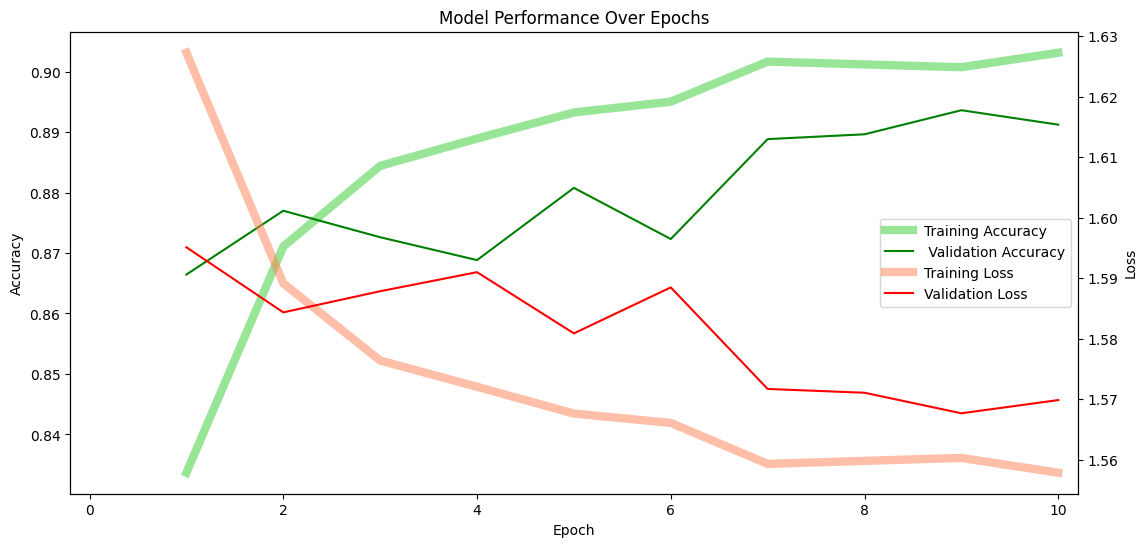

In [24]:
# Plot a graph of loss and accuracy changes per epoch.
metrics.plot_loss_vs_accuracy()

In [25]:
# Classification report of the model. Class names can be passed as a parameter here, if they are not already provided.
metrics.classification_report()

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.79      0.83      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.83      0.83      0.83      1000
       Dress       0.86      0.91      0.89      1000
        Coat       0.82      0.84      0.83      1000
      Sandal       0.94      0.98      0.96      1000
       Shirt       0.72      0.71      0.72      1000
     Sneaker       0.96      0.93      0.94      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.96      0.97      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [26]:
# Printed confusion matrix
metrics.confusion_matrix()

tensor([[792,   1,  10,  48,   7,   6, 125,   0,  11,   0],
        [  0, 971,   0,  21,   3,   0,   3,   0,   2,   0],
        [ 21,   1, 831,  10,  72,   2,  62,   0,   1,   0],
        [  6,   6,   9, 914,  29,   2,  33,   0,   1,   0],
        [  0,   2,  87,  26, 838,   0,  46,   0,   1,   0],
        [  0,   0,   0,   0,   0, 982,   0,  10,   0,   8],
        [ 96,   0,  69,  38,  68,   0, 715,   0,  14,   0],
        [  0,   0,   0,   0,   0,  35,   0, 931,   0,  34],
        [  1,   1,   1,   7,   3,   5,   4,   4, 973,   1],
        [  0,   0,   0,   0,   0,   8,   0,  26,   0, 966]], device='cuda:0')


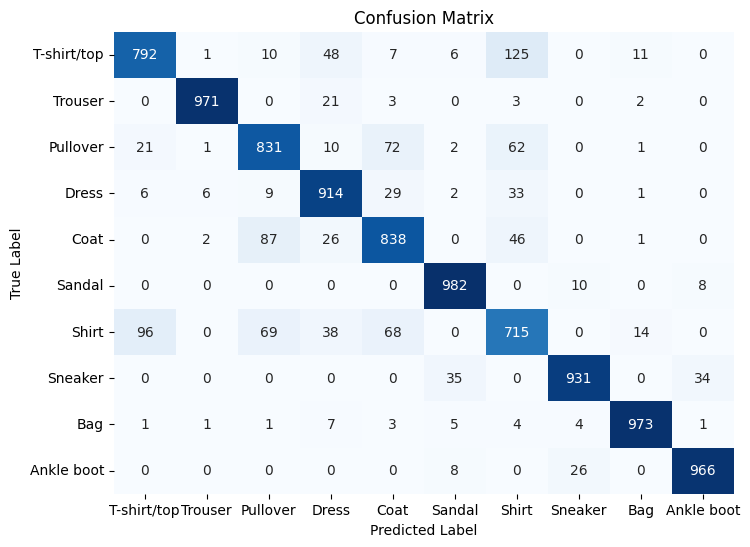

In [27]:
# Plotted confusion matrix.
metrics.plot_confusion_matrix()

<Figure size 800x800 with 0 Axes>

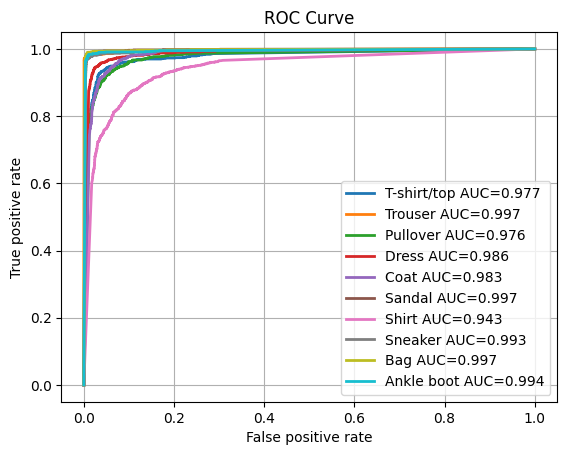

In [28]:
# ROC/AUC Curve for the model
metrics.plot_roc()

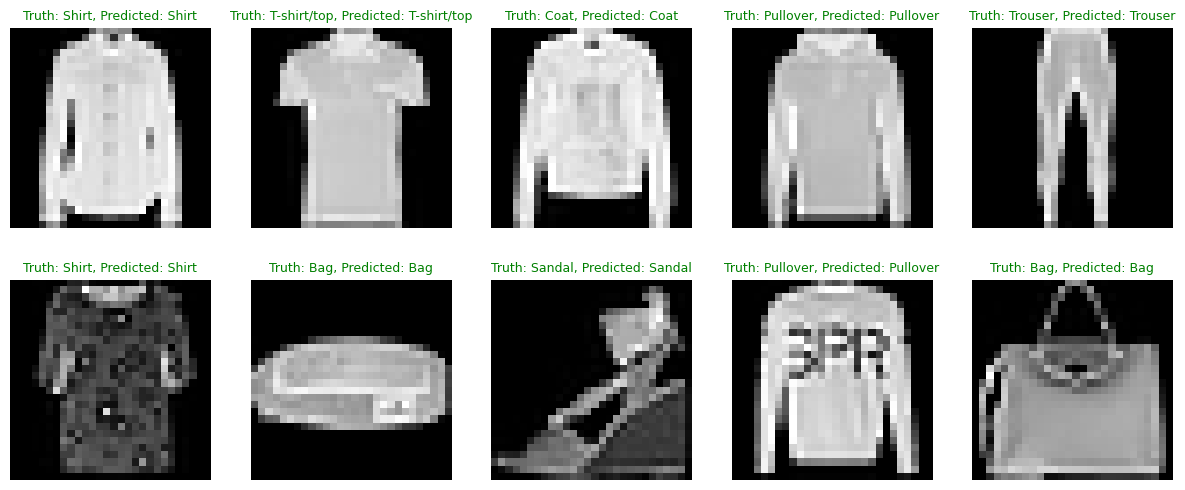

In [29]:
# Display a few cases from the test _class, with image, truth label and predicted label.
metrics.image_prediction_vs_truth(rows=2, cols=5)